In [23]:
import csv
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Reading and Merging Data

Our data is split between multiple files, which we will peek into using this script. Based on the information in those files, I'd like to populate the following dictionaries. Each dictionary name is formatted as `key_value` to help us remember which values are being mapped to one another. For example, `movieId_movieName` is a dictionary whose keys store movie ID numbers, and values store movie titles.

In [ ]:
movieId_movieName = {} 
userId_rating     = {} 
movieId_isRated   = {} # stores boolean T/F if a movie has been rated by 1+ users

movieId_movieCol  = {} 
userId_userRow    = {} 

We'll start with the movies.csv file. The cells below read the csv into a dataframe, print the first few rows, and the shape. We see that it stores.

In [3]:
filename = 'movies.csv'
df = pd.read_csv('data/{}'.format(filename))

In [4]:
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df.shape

(9125, 3)

Now we can start populating the relevant dictionaries we declared at the start of the script. We'll iterate through the dataframe, taking the movieId as the unique index. From this, we can populate the `movieId_movieName` dictionary. Since this is a comprehensive list of movies in our dataset, we'll give everything a default `isRated` value of 0--meaning that this movie is not yet rated by any users.

In [6]:
for index, row in df.iterrows():
    movieId = row['movieId']
    # movieID is the unique index
    movieId_movieName[movieId] = row['title']

    # Give default rating of 0
    movieId_isRated[movieId] = 0 

Next we can open the ratings csv file in the same manner. This file contains user ratings for movies based on movieId. We will use this information to fill in the `userId_rating` dictionary. As we work through user ratings, we'll update a movie's `isRated` status if to 1 if it receives a rating. After we're done iterating through the dataset, we'll remove any movies from `movieId_movieName` if it has not received any ratings.

In [7]:
filename = 'ratings.csv'
df = pd.read_csv('data/{}'.format(filename))

Here is a preview of the ratings.csv dataset, followed by a simple print of its shape, showing that a total of 100004 ratings exist. 

In [8]:
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
df.shape

(100004, 4)

Although the primary purpose of this script isn't EDA, we can plot a distribution of the movie ratings to get a sense of how users often rate films. Based on the figure below, it seems that there is a selection bias happening! Given that 5/5 ratings are the most common, it may be the case that users are more likely to rate a film that they enjoyed, and not leave any rating for a film they didn't like or even disliked.

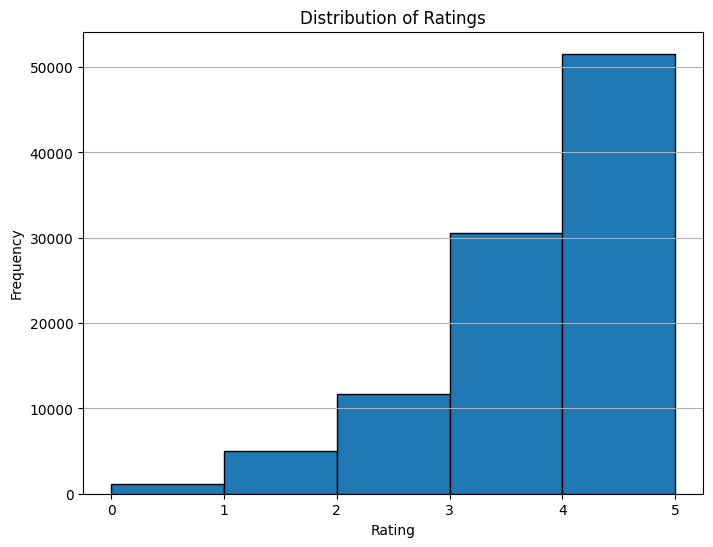

In [20]:
# Plot histogram of ratings
plt.figure(figsize=(8, 6))
plt.hist(df['rating'], bins=np.arange(0, 6, 1), edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(np.arange(0.0, 6.0, 1.0))
plt.grid(axis='y')
plt.show()

In addition to checking what scores are most often given by users in their ratings, we can check how many ratings we have per user. Below is a distribution of this quantity, showing us that the vast majority of users do not rate any movies. This means we will probably have a sparse user-movie data matrix. 

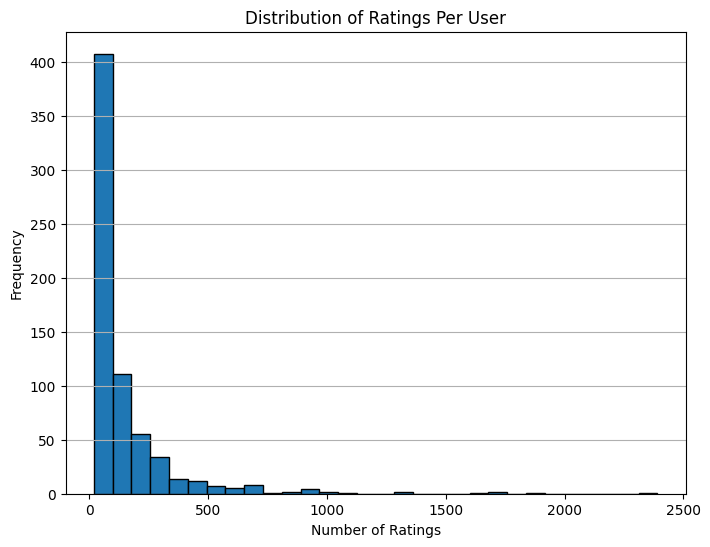

In [31]:
# Count the number of ratings per user
user_ratings_count = df.groupby('userId')['rating'].count()

# Plot histogram of ratings per user
plt.figure(figsize=(8, 6))
plt.hist(user_ratings_count, bins=30, edgecolor='black')
plt.title('Distribution of Ratings Per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Now we'll iterate through the rows of the dataframe previewed above. From each row, we'll read in the userId, movieId, and rating. For the purposes of this project, we don't need the timestamp column. The relevant dictionaries that can be updated with the new information are `userId_rating` and `movieId_isRated`.

In [10]:
for index, row in df.iterrows():
    userId = row['userId']
    movieId = row['movieId']
    rating = row['rating']

    if userId not in userId_rating.keys():
        userId_rating[userId] = [(movieId, rating)]
    else:
        userId_rating[userId].append((movieId, rating))

    movieId_isRated[movieId] = 1

for movieId, isRated in movieId_isRated.items():
    if isRated == 0:
        del movieId_movieName[movieId]

Now we will start creating a matrix of ratings where row i represents user i and column j represents movie j. So cell (i,j) is the rating from userId i for movieId j. To start creatig this matrix, we will first fill in the dictionary `movieId_movieCol` and `userId_userRow`. As a reminder, `movieId_movieCol` is a dictionary that returns the column number associated with a given movieId in the data matrix. Why not just use the same movieId as the column number? We could do this if we had movieIds that didn't skip an integer, but with the describe statement printed below, we see that the max Id is 163949, while the number of unique Ids is 100004. Clearly, there are many integers being skipped. Since we don't want to have a large matrix storing empty data, it makes more sense to just reindex the movieIds in increasing order. 

In [14]:
df.movieId.describe()

count    100004.000000
mean      12548.664363
std       26369.198969
min           1.000000
25%        1028.000000
50%        2406.500000
75%        5418.000000
max      163949.000000
Name: movieId, dtype: float64

In [11]:
i = 0
for movieId in sorted(movieId_movieName):
    movieId_movieCol[movieId] = i
    i+=1

i=0
for userId in sorted(userId_rating):
    userId_userRow[userId] = i
    i+=1

Now we'll create the matrix, starting with an initiation of an empty matrix with the correct number of rows (total users) and colums (total movies). Next, we'll update cells to store user ratings for those combinations of (i,j) that hold non-zero ratings. 

In [30]:
m = len(userId_userRow.keys())   # number of userId
n = len(movieId_movieCol.keys()) # number of movieId

# Create an empty matrix
A = np.zeros((m,n))              

print(A.shape)

# Iterate through each user's ratings
for userId, ratings in userId_rating.items():
    for rating in ratings:
        movieId   = rating[0]
        score     = rating[1]
        

        if (userId in userId_userRow and movieId in movieId_movieCol):
            i = userId_userRow[userId]
            j = movieId_movieCol[movieId]
            
            A[i,j] = score

ratingCount = 0
for i in range(m):
    for j in range(n):
        if (A[i][j] != 0):
            ratingCount += 1

print('Number of ratings = {}'.format(ratingCount))
print('Total entries = {}'.format(m*n))
print('Sparsity = {:.3}%'.format(ratingCount*100/(m*n)))

(671, 9066)
Number of ratings = 100004
Total entries = 6083286
Sparsity = 1.64%


The sparsity above indicates the fraction of cells that are nonzero in the data matrix. Only 1.64% of user-movie combinations have ratings. Below is a visualization using the first 50 users and movies.

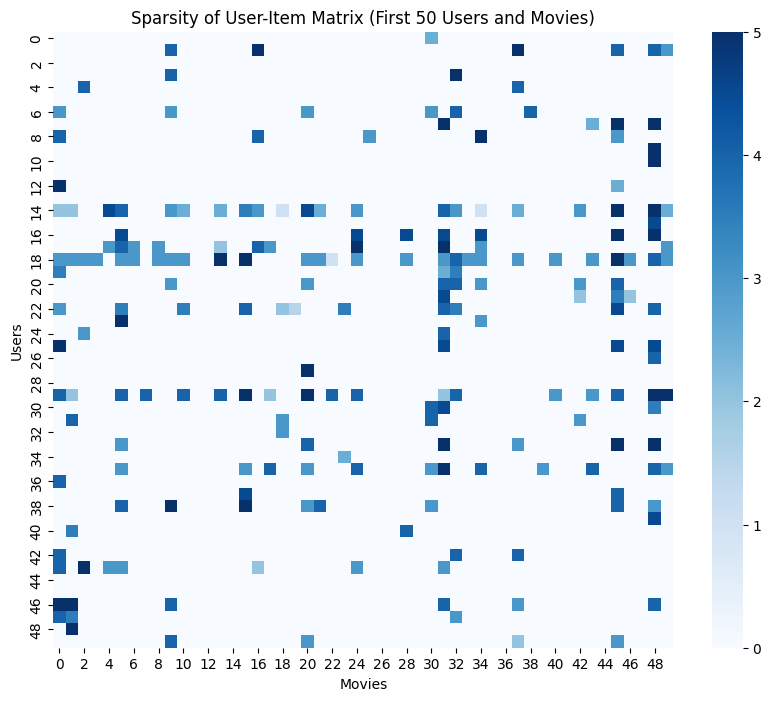

In [29]:
# Plot sparsity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(A[:50, :50], cmap='Blues', cbar=True)
plt.title('Sparsity of User-Item Matrix (First 50 Users and Movies)')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()

Now we'll store our files into pickle format, which are binary files that hold Python objects and can easily be read in to recover our dictionaries by other Python scripts.

In [13]:
d = {'movieId_movieName': movieId_movieName,
     'movieId_movieCol' : movieId_movieCol,
     'userId_userRow'   : userId_userRow,
     'userId_rating'    : userId_rating }
pickle.dump(A, open('data/data_matrix.p', 'wb'))
pickle.dump(d, open('data/data_dicts.p', 'wb'))
print (A.shape)

(671, 9066)
